In [1]:
from rapidz import Stream

Rapidz is all about streaming data processing

Streams of data can come from a whole bunch of sources, we most commonly deal with them from scientific instruments.

Rapidz's job is to provide a way to seperate the numerical logic (numpy, scipy, etc.) from the streaming flow control logic.

This is especially important for straming data since data can be pushed into the pipeline at different data rates, asynchronously, and semi-indefinately.


## Outline
1. Basic node types
1. How nodes work under the hood
1. Simple SHED nodes
1. Parallel Rapidz nodes
1. Provenance SHED nodes
1. Emerging trends in implementation (chunking + linking)
1. The XPD data processing system (servers, pipelines, all the things!)

I'd like to get through the first 3, the rest are active research/design (although fun and interesting)

## Operator Nodes

Operator nodes perform some operation on the data, transforming it

In [4]:
# Make a function
def increment(x):
    return x + 1

# Initialize a stream where we will push data into
source = Stream()
# Map increment on any data coming in
inc = source.map(increment)
# and print it
sk = inc.sink(print)

In [9]:
print(sk.args, sk.upstreams, sk.downstreams)

() [<map: increment>] <rapidz.orderedweakset.OrderedWeakrefSet object at 0x7f10496e8a20>


An important thing to note here is that the data analysis (simple as it is) is seperate from any data itself.

In [3]:
source.emit(1)
source.emit(2)
source.emit(10)

2
3
11


We can also sink to a list for later use

In [4]:
L = inc.sink_to_list()

In [5]:
for i in range(5):
    source.emit(i)

1
2
3
4
5


In [6]:
L

[1, 2, 3, 4, 5]

Map and sink don't store state on their own

Accumulate provides some state storage, allowing for things like running sums and averages

In [11]:
def add(x, y):
    return x + y

source = Stream()
source.accumulate(add).sink(print)

Output()

In [12]:
for i in range(5):
    source.emit(i)

0
1
3
6
10


Accumulate can also store a state different from the returned value

In [13]:
def num_distinct(state, new):
    state.add(new)
    return state, len(state)

source = Stream()
# return_state tells the node that our function returns state, output value
source.accumulate(num_distinct, returns_state=True, start=set()).sink(print)

Output()

In [14]:
source.emit('cat')
source.emit('dog')
source.emit('cat')

1
2
2


## Flow control

Flow control nodes can control how the data flows through the pipeline

In [15]:
source = Stream()
# filter removes data which doesn't meet the criteria
source.filter(lambda x: len(x) >= 5).sink(print)

source.emit('abcd')
source.emit('abcde')

abcde


unique nodes make sure that only unique data is used

In [16]:
source = Stream()
source.unique().sink(print)

source.emit('hi')
source.emit('world')
source.emit('hi')

hi
world


In [17]:
source = Stream()
source.unique().sink(print)

# Note that this would only work with rapidz
source.emit({'foo': 'bar'})
source.emit({'foo': 'bar'})
source.emit({'foo': 'baz'})

{'foo': 'bar'}
{'foo': 'baz'}


In [18]:
source = Stream()
source.sliding_window(3).sink(print)

for i in range(5):
    source.emit(i)

(0, 1, 2)
(1, 2, 3)
(2, 3, 4)


## Branching and Joining

Branching and joining are potentially the most important part of rapidz.
Most of the other parts could be implemented with generators and classes, however branching and joinng requires reference counting with `tee` to work properly.

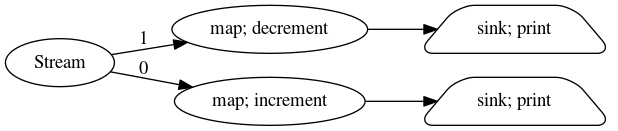

In [19]:
def increment(x):
    return x + 1

def decrement(x):
    return x - 1

source = Stream()
a = source.map(increment)

a.sink(print)
b = source.map(decrement)

b.sink(print)
b.visualize(rankdir='LR')

In [20]:
source.emit(1)

2
0


Note that because the increment node was created first it is executed first (hence 2 prints before 0) as shown in the graph by the edge labels

We can modify this with ``move_to_first`` which will move a given node to be the first in the execution stack

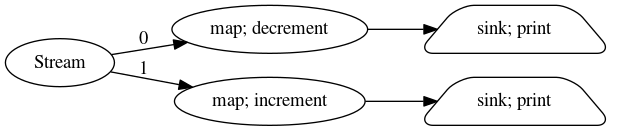

In [21]:
from rapidz.core import move_to_first

move_to_first(b)
b.visualize(rankdir='LR')


In [18]:
source.emit(1)

0
2


This can become important when you want data to be sent elsewhere before performing more computation

Data can also be combined via zip and combined_latest nodes

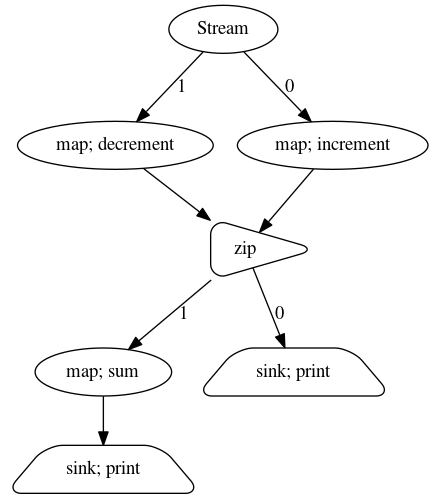

In [22]:
source = Stream()
a = source.map(increment)
b = source.map(decrement)
c = a.zip(b)
c.sink(print)
d = c.map(sum).sink(print)
source.visualize()

In [23]:
source.emit(10)

(11, 9)
20


zip nodes expect a 1 to 1 correspondance between data

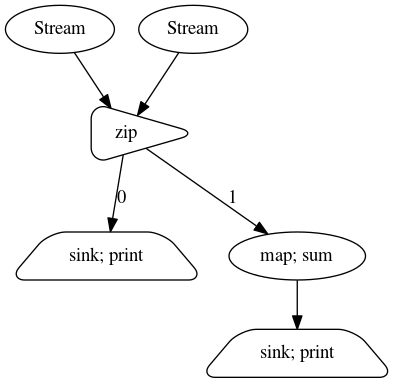

In [24]:
a = Stream()
b = Stream()
c = a.zip(b)
c.sink(print)
d = c.map(sum).sink(print)
a.visualize()

In [25]:
for i in range(5):
    a.emit(i)

### Nothing happened!!!!!

In [26]:
for j in range(5):
    b.emit(-j)

(0, 0)
0
(1, -1)
0
(2, -2)
0
(3, -3)
0
(4, -4)
0


combine_latest is less picky

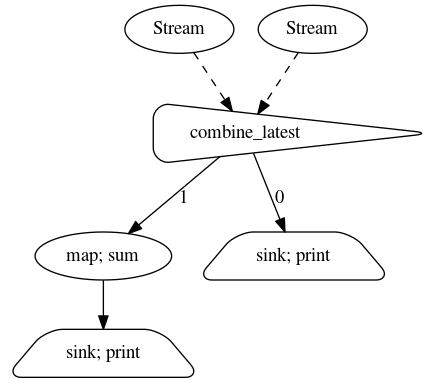

In [27]:
a = Stream()
b = Stream()
c = a.combine_latest(b)
c.sink(print)
d = c.map(sum).sink(print)
a.visualize()

In [28]:
a.emit(1)
b.emit(2)

(1, 2)
3


In [29]:
b.emit(3)

(1, 3)
4


We can also tune combine_latest only issue data when the data is coming from a certain node

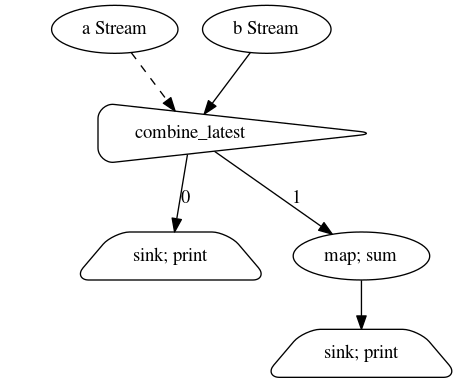

In [30]:
a = Stream(stream_name='a')
b = Stream(stream_name='b')
c = a.combine_latest(b, emit_on=a)
c.sink(print)
d = c.map(sum).sink(print)
a.visualize()

In [31]:
a.emit(1)
b.emit(2)

In [32]:
b.emit(3)

In [33]:
a.emit(5)

(5, 3)
8


## Questions?

## How this all works under the hood (mostly)

Here is a simplified version of the base class (I've left off the async and IO loop handling)

In [ ]:
class Stream(object):
    """ A Stream is an infinite sequence of data

    Streams subscribe to each other passing and transforming data between them.
    A Stream object listens for updates from upstream, reacts to these updates,
    and then emits more data to flow downstream to all Stream objects that
    subscribe to it.  Downstream Stream objects may connect at any point of a
    Stream graph to get a full view of the data coming off of that point to do
    with as they will.


    Examples
    --------
    >>> def inc(x):
    ...     return x + 1

    >>> source = Stream()  # Create a stream object
    >>> s = source.map(inc).map(str)  # Subscribe to make new streams
    >>> s.sink(print)  # take an action whenever an element reaches the end

    >>> L = list()
    >>> s.sink(L.append)  # or take multiple actions (streams can branch)

    >>> for i in range(5):
    ...     source.emit(i)  # push data in at the source
    '1'
    '2'
    '3'
    '4'
    '5'
    >>> L  # and the actions happen at the sinks
    ['1', '2', '3', '4', '5']
    """

    _graphviz_shape = "ellipse"
    _graphviz_style = "rounded,filled"
    _graphviz_fillcolor = "white"
    _graphviz_orientation = 0

    str_list = ["func", "predicate", "n", "interval"]

    def __init__(
        self,
        upstream=None,
        upstreams=None,
        stream_name=None,
    ):
        self.downstreams = OrderedWeakrefSet()
        if upstreams is not None:
            self.upstreams = list(upstreams)
        else:
            self.upstreams = [upstream]

        for upstream in self.upstreams:
            if upstream:
                upstream.downstreams.add(self)

        self.name = stream_name

    def emit(self, x):
        result = []
        for downstream in list(self.downstreams):
            r = downstream.update(x, who=self)
            if type(r) is list:
                result.extend(r)
            else:
                result.append(r)

        return [element for element in result if element is not None]

    def update(self, x, who=None):
        self._emit(x)


The basic methods, ``__init__``, ``emit``, and ``update`` (``emit`` is usually the same across nodes)

In [ ]:
class map(Stream):
    """ Apply a function to every element in the stream

    Parameters
    ----------
    func: callable
    *args :
        The arguments to pass to the function.
    **kwargs:
        Keyword arguments to pass to func

    Examples
    --------
    >>> source = Stream()
    >>> source.map(lambda x: 2*x).sink(print)
    >>> for i in range(5):
    ...     source.emit(i)
    0
    2
    4
    6
    8
    """

    def __init__(self, upstream, func, *args, **kwargs):
        self.func = func
        # this is one of a few stream specific kwargs
        stream_name = kwargs.pop("stream_name", None)
        self.kwargs = kwargs
        self.args = args

        Stream.__init__(self, upstream, stream_name=stream_name)

    def update(self, x, who=None):
        try:
            result = self.func(x, *self.args, **self.kwargs)
        except Exception as e:
            logger.exception(e)
            raise
        else:
            return self.emit(result)